In [3]:
import logging
logging.basicConfig(filename='regressing-manski.log', level=logging.INFO)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/manski-bound-regression/'

In [5]:
col_name = 'Temp_C'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [6]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [7]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [8]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [9]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2][[
       'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR',
       'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
       'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
       'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
       'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
       'Arterial_BE', 'HCO3', 'Arterial_lactate']].reset_index()

MIMICtable_filtered_t0 = MIMICtable_filtered_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[col_name]>0].reset_index()
MIMICtable_filtered_t1 = MIMICtable_filtered_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index()
MIMIC_data_combined = MIMICtable_filtered_t0[['gender', 'age', 'icustay_id', f'{col_name}_t0']].merge(MIMICtable_filtered_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
MIMIC_data_combined.head()

,gender,age,icustay_id,Temp_C_t0,Temp_C_t1
0,0.0,22799.404780,65537,35.833333,35.833333
1,0.0,17639.826435,3,37.444445,37.444445
2,0.0,24000.436400,65544,37.111113,37.444445
3,0.0,23940.093773,98314,36.333334,36.444446
4,0.0,30946.970000,14,36.999999,37.000000


In [10]:
pulse_data_t0 = pulse_data[pulse_data['index']==0].reset_index(drop=True)
pulse_data_t1 = pulse_data[pulse_data['index']==1].reset_index(drop=True)
pulse_data_t0 = pulse_data_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
pulse_data_t1 = pulse_data_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
pulse_data_combined = pulse_data_t0[['icustay_id', f'{col_name}_t0']].merge(pulse_data_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
pulse_data_combined = MIMICtable_filtered_t0[['gender', 'age', 'icustay_id']].merge(pulse_data_combined[['icustay_id', f'{col_name}_t0', f'{col_name}_t1']], on=['icustay_id'])
pulse_data_combined.head()

,gender,age,icustay_id,Temp_C_t0,Temp_C_t1
0,0.0,22799.404780,65537,33.151252,32.223820
1,0.0,17639.826435,3,33.130515,32.814843
2,0.0,24000.436400,65544,33.190942,33.551028
3,0.0,23940.093773,98314,33.237951,34.493438
4,0.0,30946.970000,14,33.112334,32.445347


# Supervised Learning of Actions - Logistic Regression


In [11]:
nra = 5
nr_reps = 100

In [12]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

MIMICraw = MIMIC_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
#     elif col in colnorm:
    else:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
#     else:
#         log_values = np.log(0.1 + MIMICraw[col])
#         dmu = log_values.mean()
#         dsigma = log_values.std()
#         MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


In [13]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

pulseraw = pulse_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

for col in pulseraw:
    if col in colbin:
        pulseraw[col] = pulseraw[col] - 0.5
#     elif col in colnorm:
    else:
        cmu = pulseraw[col].mean()
        csigma = pulseraw[col].std()
        pulseraw[col] = (pulseraw[col] - cmu)/csigma
#     else:
#         log_values = np.log(0.1 + MIMICraw[col])
#         dmu = log_values.mean()
#         dsigma = log_values.std()
#         MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


## Create Actions


In [14]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable_filtered_t0)) # array of ones, by default
io[MIMICtable_filtered_t0['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable_filtered_t0['max_dose_vaso'].copy()
vc_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable_filtered_t0.loc[io==1, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==2, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==3, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==4, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable_filtered_t0.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [15]:
len(actionbloc)

6174

## Fitting models

In [344]:
# from sklearn.linear_model import LogisticRegression
# icuuniqueids = MIMIC_data_combined['icustay_id'].unique()
# modelsDf = pd.DataFrame()

# logging.info('Fitting models')

# for model in tqdm(range(nr_reps)):
#     logging.info('Model: ' + str(model))
#     grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
#     crossval = 1
#     trainidx = icuuniqueids[grp != crossval]
#     testidx = icuuniqueids[grp == crossval]
#     X = MIMICraw.loc[MIMIC_data_combined['icustay_id'].isin(trainidx)]
#     Xtestmimic = MIMICraw[MIMIC_data_combined['icustay_id'].isin(testidx)]
#     ptid = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
#     ptidtestmimic = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'icustay_id']
#     Y = actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc']
#     Ytest = actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc']
#     clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
#     acc_train = clf.score(X, Y)
#     acc_test = clf.score(Xtestmimic, Ytest)
#     modelsDf = modelsDf.append({'model': model, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
# logging.info('Model fitting done!')

In [345]:
# clf.predict_proba(Xtestmimic)

In [346]:
# modelsDf

# Fit $\pi(a_0\mid x_0)$ using Neural Net

In [16]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [348]:
icuuniqueids = MIMIC_data_combined['icustay_id'].unique()
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMIC_data_combined['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMIC_data_combined['icustay_id'].isin(testidx)].values)
    ptid = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMIC_data_combined.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1
    Ytest = torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1
    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)
    
    loss_func = torch.nn.CrossEntropyLoss()
    policy = PolicyNetwork(input_dim=3, output_dim=25)
    optimizer = torch.optim.SGD(policy.parameters(), lr=0.01)
    
    for epoch in range(100):
        for data, label in trainloader:
            prediction = policy(data)     # input x and predict based on x
            loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    torch.save(policy.state_dict(), f'{models_dir}/policy_{model}')
    

100%|██████████| 100/100 [09:10<00:00,  5.51s/it]


In [349]:
loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=3, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.01)

In [350]:
losses = []

for epoch in tqdm(range(100)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


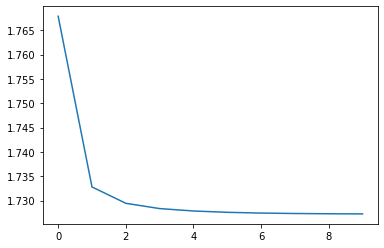

In [351]:
plt.plot(losses)

In [352]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtestmimic)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 51 %


# Regressing $\mathbb{E}[Y^{obs}\mid x,a]$

In [17]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [487]:
net = Net(n_feature=4, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=1)
loss_func = torch.nn.MSELoss()

In [488]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    A = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    Atest = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    
    net = Net(n_feature=4, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=1)
    loss_func = torch.nn.MSELoss()
    
    for t in range(1000):  
        prediction = net(torch.column_stack((X,A)))     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/yobs_{model}')

100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


In [464]:
A = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
Atest = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
prediction = net(torch.column_stack((X,A)))


In [465]:
# train the network
losses = []
for t in tqdm(range(1000)):
  
    prediction = net(torch.column_stack((X,A)))     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(net(torch.column_stack((Xtestmimic,Atest))), Ytest)
        losses.append(test_loss.item())


100%|██████████| 1000/1000 [00:00<00:00, 2258.48it/s]


0.6479947566986084

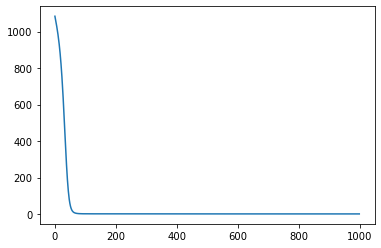

In [466]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [473]:
x = torch.FloatTensor((0.5,-0.17, -0.89, 14))
net(x)

tensor([53.4787], grad_fn=<AddBackward0>)

In [360]:
X

tensor([[-0.5000, -0.1808, -0.9452],
        [-0.5000, -1.0452,  0.5158],
        [-0.5000,  0.0205,  0.2135],
        ...,
        [-0.5000, -1.6482, -0.2399],
        [ 0.5000,  1.5926,  1.1204],
        [ 0.5000,  0.7394, -0.1895]])

# Regressing $\mathbb{E}[Y^{min}\mid x,a]$

In [18]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class QuantileNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuantileNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [19]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [363]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    
    quantile_net = QuantileNet(n_feature=3, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.1)
    loss_func = PinballLoss(quantile=0.01, reduction='mean')    

    for t in range(1000):  
        prediction = quantile_net(X)     # input x and predict based on x
        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymin_{model}')

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


In [364]:
quantile_net = QuantileNet(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.1)
loss_func = PinballLoss(quantile=0.01, reduction='mean')

In [365]:
# train the network
losses = []
for t in tqdm(range(5000)):
  
    prediction = quantile_net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(quantile_net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 5000/5000 [00:04<00:00, 1077.06it/s]


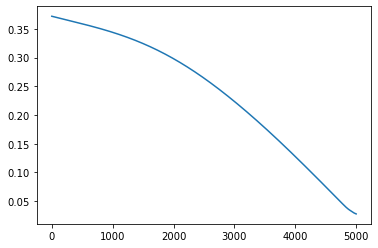

In [366]:
plt.plot(losses)

In [367]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
quantile_net(x)

tensor([34.4542], grad_fn=<AddBackward0>)

In [368]:
losses[-1]

0.027841059491038322

# Regressing $\mathbb{E}[Y^{max}\mid x,a]$

In [369]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMIC_data_combined.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    
    quantile_net = QuantileNet(n_feature=3, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.1)
    loss_func = PinballLoss(quantile=0.99, reduction='mean')    

    for t in range(1000):  
        prediction = quantile_net(X)     # input x and predict based on x
        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymax_{model}')

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [370]:
quantile_net = QuantileNet(n_feature=3, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.1)
loss_func = PinballLoss(quantile=0.99, reduction='mean')

In [371]:
# train the network
losses = []
for t in tqdm(range(5000)):
  
    prediction = quantile_net(X)     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(quantile_net(Xtestmimic), Ytest)
        losses.append(test_loss.item())


100%|██████████| 5000/5000 [00:05<00:00, 965.35it/s]


0.025340475142002106

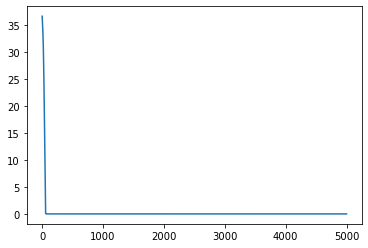

In [372]:
plt.plot(losses)
losses[-1]

In [373]:
x = torch.FloatTensor((0.5,-0.17, -0.89))
quantile_net(x)

tensor([38.4374], grad_fn=<AddBackward0>)

# Regressing $\mathbb{E}[Y^{sim}(a)\mid x]$

In [489]:
icuuniqueids = pulse_data_combined['icustay_id'].unique()
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(pulseraw.loc[pulse_data_combined['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(pulseraw[pulse_data_combined['icustay_id'].isin(testidx)].values)
    A = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
    Atest = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
    ptid = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
    
    net = Net(n_feature=4, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
    loss_func = torch.nn.MSELoss()

    for t in range(1000):  
        prediction = net(torch.column_stack((X,A)))     # input x and predict based on x
        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/ysim_{model}')

100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


In [477]:
net = Net(n_feature=4, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [478]:
icuuniqueids = pulse_data_combined['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(pulseraw.loc[pulse_data_combined['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(pulseraw[pulse_data_combined['icustay_id'].isin(testidx)].values)
A = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
Atest = (torch.tensor(actionbloc.loc[MIMIC_data_combined['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
ptid = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(trainidx), f'{col_name}_t1'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(pulse_data_combined.loc[pulse_data_combined['icustay_id'].isin(testidx), f'{col_name}_t1'].values).unsqueeze(dim=1)


In [479]:
prediction = net(torch.column_stack((X,A)))

In [480]:
# train the network
losses = []
for t in tqdm(range(1000)):
  
    prediction = net(torch.column_stack((X,A)))     # input x and predict based on x

    loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = loss_func(net(torch.column_stack((Xtestmimic,Atest))), Ytest)
        losses.append(test_loss.item())


100%|██████████| 1000/1000 [00:00<00:00, 2267.54it/s]


0.367671400308609

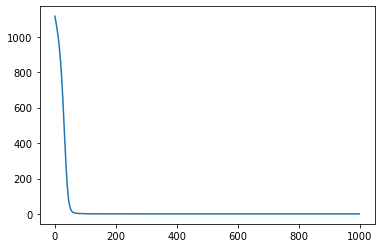

In [481]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [486]:
x = torch.FloatTensor((0.5,-0.17, -0.89, 0.4))
net(x)

tensor([32.7940], grad_fn=<AddBackward0>)

# Computing scores for simulated outcomes using saved models

In [27]:
def compute_score(gender, age, col_v, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=0)
    gender = gender - 0.5
    age_normalized_sim = (age - pulse_data_combined['age'].mean())/pulse_data_combined['age'].std()
    col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
    sim_input = torch.FloatTensor((gender, age_normalized_sim, col_normalized_sim))
    age_normalized_obs = (age - MIMIC_data_combined['age'].mean())/MIMIC_data_combined['age'].std()
    col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
    obs_input = torch.FloatTensor((gender, age_normalized_obs, col_normalized_obs))
    action_tensor = torch.FloatTensor(((action-1)/24,))
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=3, output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
        policy.eval()
        prob = softmax(policy(obs_input))[action-1]
        lb = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymin_model(obs_input))
        ub = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymax_model(obs_input))
        sim = ysim_model(torch.cat((sim_input, action_tensor)))
        p += int(((lb<=sim)&(sim<=ub)).item())
    p = p/nr_reps
    return p    

In [36]:
models_dir = "/data/localhost/taufiq/manski_bounds"
col_name = 'Temp_C'
compute_score(0, 65, 31, 0, col_name, models_dir)

In [32]:
pulse_data_t0

,index,Albumin,paCO2,paO2,ArterialPressure (mmHg),HCO3,Arterial_pH,BUN,BloodVolume (mL),Calcium,...,RR,PaO2_FiO2,SimulationTime(s),Temp_C_t0,Sodium,SysBP,WBC_count,id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,0,36949.438638,40.082410,91.855017,98.292663,1587.765562,7.412865,13.059566,5601.571764,48.187032,...,20.000000,4.647789,0.0,33.279228,3330.266997,118.768598,7000.0,75585.0,7.103817e+09,75585
2,0,36941.846898,39.893587,88.507821,87.414676,1590.467389,7.414731,13.081810,5911.672498,48.154955,...,15.544041,4.635947,0.0,33.079131,3322.906770,121.156909,7000.0,1528.0,6.412648e+09,1528
3,0,36968.735379,39.894300,91.729049,120.522155,1589.726134,7.414724,13.066101,4691.617731,48.192895,...,19.867550,4.649578,0.0,33.144292,3327.133490,120.941327,7000.0,3198.0,6.551858e+09,3198
4,0,36974.149331,39.812364,93.148442,91.794336,1589.347777,7.415537,13.286902,4193.299045,48.218215,...,20.000000,4.655116,0.0,33.193230,3331.363770,98.197739,7000.0,3874.0,7.465369e+09,3874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4938,0,36957.459563,38.763183,88.088049,78.254176,1590.106885,7.426092,13.069207,5085.766379,48.178612,...,13.392857,4.637967,0.0,32.956769,3319.250573,121.748932,7000.0,86178.0,6.952736e+09,86178
4939,0,36974.694582,39.234706,92.158148,62.054591,1589.678469,7.421314,13.122420,4370.309397,48.197037,...,15.384615,4.651236,0.0,33.085908,3326.197278,119.853455,7000.0,7416.0,4.281014e+09,7416
4940,0,36968.655014,40.048958,93.909262,100.451565,1588.504751,7.413195,13.168069,4556.555159,48.211913,...,20.000000,4.655761,0.0,33.272571,3332.271428,110.582487,7000.0,22969.0,5.934482e+09,22969
4941,0,36958.397773,39.953173,91.623685,110.180652,1588.935978,7.414141,12.976164,5348.176577,48.188460,...,16.949153,4.647318,0.0,33.188001,3327.691236,120.953546,7000.0,14178.0,5.813706e+09,14178


In [33]:
ages = range(18,66)
scores = []
for age in tqdm(ages):
    score = compute_score(0, age, 32, 2)
    scores.append(score)

100%|██████████| 48/48 [00:08<00:00,  5.53it/s]


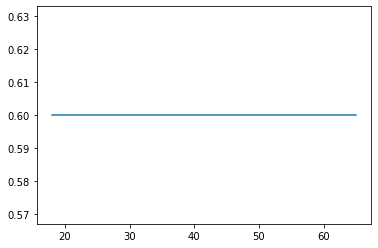

In [34]:
import matplotlib.pyplot as plt
plt.plot(ages, scores)

In [25]:
temps = range(29,35)
scores = []
for temp in tqdm(temps):
    score = compute_score(0, 40, temp, 1)
    scores.append(score)

100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


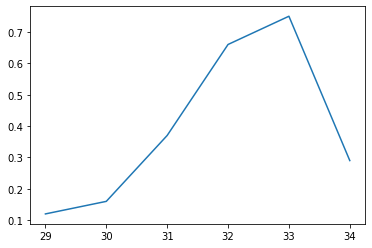

In [26]:
plt.plot(temps, scores)

In [27]:
ages = np.linspace(18,65, num=65-18 + 1)
temps = np.linspace(29,36, num=(36-29)*5 + 1)
df = pd.DataFrame()
for age in tqdm(ages):
    for temp in temps:
        score = compute_score(0, age, temp, 2)
        df = df.append({'age': age, 'temp': temp, 'score': score}, ignore_index=True)

100%|██████████| 48/48 [05:13<00:00,  6.53s/it]


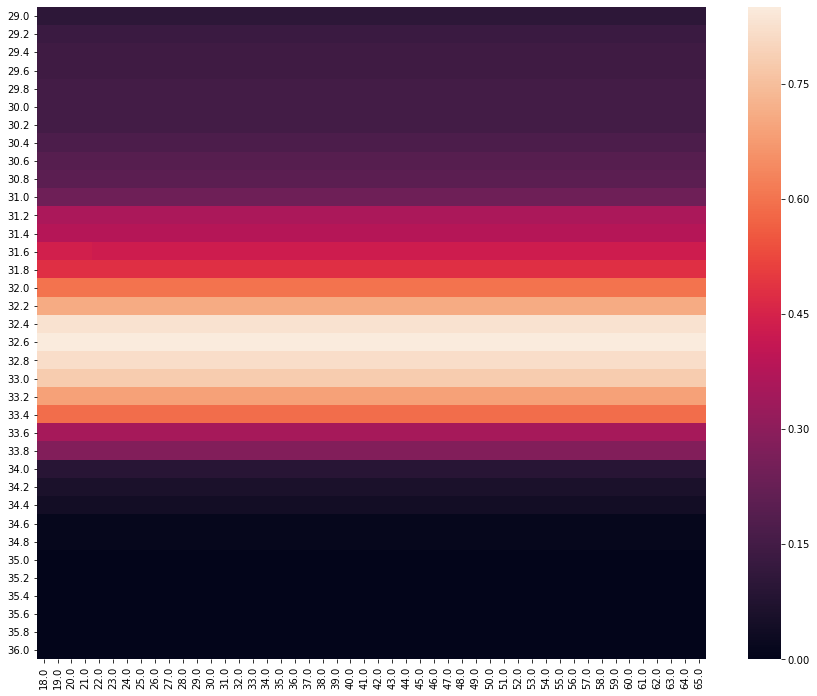

In [28]:
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter

fig, axs = plt.subplots(1, 1, figsize=(15,12))
df_pivot = df.pivot_table(index="temp", columns="age", values="score", aggfunc=np.max)
df_pivot_smooth = gaussian_filter(df_pivot, sigma=0.1)
sns.heatmap(df_pivot_smooth, vmax=df_pivot.values.max(), xticklabels=ages, yticklabels=temps, vmin=df_pivot.values.min(), ax=axs)
plt.show()

In [23]:
MIMICtable_filtered_t0['HR']

0        77.000000
1        80.000000
2        87.500000
3       111.500000
4        74.666667
           ...    
6169     98.000000
6170     64.000000
6171     48.000000
6172     92.333333
6173     63.000000
Name: HR, Length: 6174, dtype: float64

In [22]:
pulse_data_t0['HR']

0       115.384615
1       115.384615
2        65.217391
3        81.081081
4       111.111111
           ...    
4938     51.724138
4939     69.767442
4940    115.384615
4941     96.774194
4942     88.235294
Name: HR, Length: 4943, dtype: float64